In [106]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time

In [107]:
start_time = time.time()

1 Исходные данные

In [108]:
dataset_z = 1
dataset_U = 4

# Фиксация генераторов случайных чисел
random_seed_1 = 2022
random_seed_2 = 2012
np.random.seed(random_seed_1)

# Число ЛЭП
N_powerlines = 5

# Число признаков для каждой ЛЭП (в общем случае - 6, в частных случаях - 3)
N_feat = 6

# Число строк (число измерений)
N_rows = 1000

# Взаимные сопротивления ЛЭП (точные значения коэффициентов регрессии)
z_powerlines = {
    'z(1)': (0.040 + 0.0060j, 0.038 + 0.0055j, 0.036 + 0.0050j, 0.035 + 0.0048j, 0.033 + 0.0045j, 0.030 + 0.0044j),
    'z(2)': (0.020 + 0.0025j, 0.018 + 0.0022j, 0.016 + 0.0020j, 0.015 + 0.0019j, 0.014 + 0.0016j, 0.012 + 0.0014j),
    'z(3)': (0.018 + 0.0022j, 0.016 + 0.0020j, 0.015 + 0.0018j, 0.013 + 0.0016j, 0.012 + 0.0015j, 0.011 + 0.0014j),
    'z(4)': (0.016 + 0.0020j, 0.014 + 0.0018j, 0.013 + 0.0016j, 0.010 + 0.0015j, 0.009 + 0.0014j, 0.008 + 0.0012j),
    'z(5)': (0.015 + 0.0018j, 0.014 + 0.0016j, 0.013 + 0.0015j, 0.011 + 0.0012j, 0.010 + 0.0012j, 0.009 + 0.0010j),
}

# Доли участков датасета с различными направлениями передачи энергии
data_size_1 = 0.35
data_size_2 = 0.25

# Начальные значения токов фазы А (на начало измерений) для участков датасета с различными направлениями передачи энергии
I_1 = {
    'A(1)': (200, 200),
    'A(2)': (125, 125),
    'A(3)': (220, 220),
    'A(4)': (300, 300),
    'A(5)': (170, 170),
}

delta_I_2 = {
    'A(1)': (-700, -700),
    'A(2)': (0, 0),
    'A(3)': (0, 0),
    'A(4)': (0, 0),
    'A(5)': (0, 0),
}

delta_I_3 = {
    'A(1)': (0, 0),
    'A(2)': (0, 0),
    'A(3)': (-800, -800),
    'A(4)': (0, 0),
    'A(5)': (0, 0),
}

# Коэффициенты увеличения начальных значений токов фазы А на конец измерений для каждой ЛЭП
k_current = {
    'k(1)': 1.1,
    'k(2)': 1.1,
    'k(3)': 1.1,
    'k(4)': 1.1,
    'k(5)': 1.1,
}

# Максимальное абсолютное значение шума напряжений (элементов вектора b_d)
noise_b = 0.0

# Отн. погрешности измерений значений токов (элементов матрицы A_h) и напряжений (элементов вектора b_d)
k_A = 0.010
k_b = 0.050

# Пути для записи датасетов
output_path_z = f'C:/Datasets/dataset_z_powerlines_{dataset_z}.xlsx'
output_path_dat_0 = f'C:/Datasets/dataset_voltage_0_{dataset_z}_{dataset_U}.xlsx'
output_path_dat = f'C:/Datasets/dataset_voltage_{dataset_z}_{dataset_U}.xlsx'

2 Запись точных коэффициентов регрессии z_powerlines в файл

In [109]:
df_z_powerlines = pd.DataFrame(z_powerlines)
df_z_powerlines.to_excel(output_path_z, index=False, float_format='%.20f')

3 Преобразование форматов исходных данных

3.1 Генерация начальных значений фазных токов ЛЭП (на начало измерений) для участков датасета с различными направлениями передачи энергии

In [110]:
# Комплексные операторы поворота фазных токов
b_rot = complex(-0.5, -1 * np.sqrt(3) / 2)
c_rot = complex(-0.5, np.sqrt(3) / 2)

def calculate_initial_currents(I_dict):
    A = ()
    I_full = {}

    for key in I_dict:
        values = I_dict[key]
        a1, a2 = values

        key_values = [a1, a1 * b_rot, a1 * c_rot, 
                      a2, a2 * b_rot, a2 * c_rot]

        I_full[key] = key_values
        A += tuple(key_values)

    return I_full, A

I_full_1, A_1 = calculate_initial_currents(I_1)
I_full_2, A_2 = calculate_initial_currents(delta_I_2)
I_full_3, A_3 = calculate_initial_currents(delta_I_3)

In [111]:
# Создание вектора взаимных сопротивлений ЛЭП из словаря z_powerlines
z = ()

for key in z_powerlines:
    values = z_powerlines[key]
    z += tuple(values)

In [112]:
# Создание словаря k_current_full значений итогового увеличения токов (в начале и конце ЛЭП) для всех фазных проводов ЛЭП
k_current_full = {}

for key in k_current:
    values = k_current[key]
    a_k = values
    key_values = [a_k, a_k, a_k,
                  a_k, a_k, a_k]
    k_current_full[key] = key_values

In [113]:
# Создание вектора коэффициентов увеличения начальных значений токов (фазы А)
k_curr = ()

for key in k_current_full:
    values = k_current_full[key]
    k_curr += tuple(values)

4 Формирование матрицы A и вектора b

In [114]:
N_1 = int(N_rows * data_size_1)
N_2 = int(N_rows * (data_size_1 + data_size_2))

# Создание пустой матрицы A
A = np.zeros((N_rows, N_powerlines * N_feat)).astype(complex)

# Заполнение первой строки первого участка матрицы A
A[0] = A_1

# Заполнение остальных строк первого участка матрицы A
for i in range(1, N_1):
    A[i] = A[i-1]
    for j in range(N_powerlines * N_feat):
        A[i, j:j+1] *= np.random.uniform(1, 1 + k_curr[j] / N_rows)
        if j % 3 == 0:    # Искусственное задание несимметрии токов
            A[i, j:j+1] *= np.random.uniform(1, 1 + 0. / N_rows)

# Заполнение первой строки второго участка матрицы A
A[N_1] = A[N_1 - 1] + A_2

# Заполнение остальных строк второго участка матрицы A
for i in range(N_1 + 1, N_2):
    A[i] = A[i-1]
    for j in range(N_powerlines * N_feat):
        A[i, j:j+1] *= np.random.uniform(1, 1 + k_curr[j] / N_rows)
        if j % 3 == 0:    # Искусственное задание несимметрии токов
            A[i, j:j+1] *= np.random.uniform(1, 1 + 0. / N_rows)

# Заполнение первой строки третьего участка матрицы A
A[N_2] = A[N_2 - 1] + A_3

# Заполнение остальных строк третьего участка матрицы A
for i in range(N_2 + 1, N_rows):
    A[i] = A[i-1]
    for j in range(N_powerlines * N_feat):
        A[i, j:j+1] *= np.random.uniform(1, 1 + k_curr[j] / N_rows)
        if j % 3 == 0:    # Искусственное задание несимметрии токов
            A[i, j:j+1] *= np.random.uniform(1, 1 + 0. / N_rows)

# Формирование столбца значений целевой переменной b
b = np.sum(A * z, axis=1)
# Генерация названий столбцов
column_names_0 = []

for i in range(1, N_powerlines + 1):
    for j in range(1, int(N_feat/3) + 1):
        column_names_0.append(f"a{j}_{i}")
        column_names_0.append(f"b{j}_{i}")
        column_names_0.append(f"c{j}_{i}")

df_0 = pd.DataFrame(A, columns=column_names_0)
df_0["b"] = b

df_0.to_excel(output_path_dat_0, index=False, float_format='%.20f')
df_0.head()

,a1_1,b1_1,c1_1,a2_1,b2_1,c2_1,a1_2,b1_2,c1_2,a2_2,...,a2_4,b2_4,c2_4,a1_5,b1_5,c1_5,a2_5,b2_5,c2_5,b
0,200.000000+0.000000j,-100.000000-173.205081j,-100.000000+173.205081j,200.000000+0.000000j,-100.000000-173.205081j,-100.000000+173.205081j,125.000000+0.000000j,-62.500000-108.253175j,-62.500000+108.253175j,125.000000+0.000000j,...,300.000000+0.000000j,-150.000000-259.807621j,-150.000000+259.807621j,170.000000+0.000000j,-85.000000-147.224319j,-85.000000+147.224319j,170.000000+0.000000j,-85.000000-147.224319j,-85.000000+147.224319j,4.867472-1.865653j
1,200.002059+0.000000j,-100.012472-173.226683j,-100.005497+173.214602j,200.150709+0.000000j,-100.098742-173.376107j,-100.071220+173.328437j,125.123332+0.000000j,-62.557156-108.352172j,-62.556895+108.351721j,125.114617+0.000000j,...,300.070023+0.000000j,-150.093171-259.968998j,-150.057656+259.907484j,170.182495+0.000000j,-85.074264-147.352948j,-85.033462+147.282277j,170.139869+0.000000j,-85.034844-147.284670j,-85.090217+147.380578j,4.867837-1.873225j
2,200.019964+0.000000j,-100.045124-173.283238j,-100.045507+173.283901j,200.258727+0.000000j,-100.172891-173.504537j,-100.134196+173.437514j,125.134425+0.000000j,-62.559797-108.356747j,-62.610720+108.444948j,125.119662+0.000000j,...,300.091243+0.000000j,-150.167815-260.098285j,-150.198605+260.151616j,170.257646+0.000000j,-85.157029-147.496300j,-85.094445+147.387903j,170.285205+0.000000j,-85.125217-147.441201j,-85.120380+147.432823j,4.864178-1.877437j
3,200.084467+0.000000j,-100.084552-173.351529j,-100.062913+173.314050j,200.260504+0.000000j,-100.241919-173.624097j,-100.230182+173.603768j,125.220508+0.000000j,-62.590932-108.410673j,-62.624107+108.468135j,125.249705+0.000000j,...,300.301399+0.000000j,-150.201713-260.156999j,-150.322215+260.365713j,170.288682+0.000000j,-85.193058-147.558705j,-85.117948+147.428611j,170.330439+0.000000j,-85.127177-147.444596j,-85.204174+147.577958j,4.861554-1.876632j
4,200.180457+0.000000j,-100.184213-173.524147j,-100.124532+173.420776j,200.284558+0.000000j,-100.332636-173.781224j,-100.311605+173.744797j,125.356655+0.000000j,-62.658961-108.528504j,-62.674138+108.554792j,125.332383+0.000000j,...,300.384759+0.000000j,-150.280869-260.294100j,-150.484364+260.646564j,170.306704+0.000000j,-85.251996-147.660788j,-85.205749+147.580686j,170.484588+0.000000j,-85.148332-147.481237j,-85.288883+147.724678j,4.854971-1.877023j


5 Датасет тока небаланса для матрицы A и вектора b

In [115]:
df_0_sum = pd.DataFrame()

for i in range(0, N_powerlines * N_feat, 3):
    feature_group_0 = df_0.iloc[:, i:i+3]
    sum_features_0 = feature_group_0.sum(axis=1)
    df_0_sum[f'Jo_{i//3 + 1}'] = sum_features_0

df_0_sum['b'] = df_0['b']
df_0_sum.head()

,Jo_1,Jo_2,Jo_3,Jo_4,Jo_5,Jo_6,Jo_7,Jo_8,Jo_9,Jo_10,b
0,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,4.867472-1.865653j
1,-0.015910-0.012081j,-0.019172-0.047670j,0.009282-0.000451j,0.055294+0.015098j,-0.047788-0.184659j,0.052909+0.095106j,-0.200632-0.135919j,-0.080803-0.061514j,0.074769-0.070671j,0.014809+0.095908j,4.867837-1.873225j
2,-0.070667+0.000663j,-0.048360-0.067022j,-0.036093+0.088201j,0.028415+0.021496j,0.020918-0.081905j,-0.005150-0.010985j,-0.198872-0.392342j,-0.275177+0.053330j,0.006172-0.108397j,0.039653-0.008378j,4.864178-1.877437j
3,-0.062998-0.037479j,-0.211561-0.020329j,0.005541+0.057462j,0.093413+0.115341j,0.175191-0.092218j,-0.024716-0.113729j,-0.414213-0.342809j,-0.222529+0.208714j,-0.022324-0.130094j,-0.000912+0.133362j,4.861554-1.876632j
4,-0.128289-0.103371j,-0.359683-0.036427j,0.023556+0.026288j,0.156059+0.132558j,0.099505+0.013427j,-0.085928-0.071147j,-0.275218-0.318498j,-0.380473+0.352464j,-0.151004-0.080102j,0.047373+0.243442j,4.854971-1.877023j


6 Генерация матрицы A_h и вектора b_d, заданных с погрешностями k_A и k_b

In [116]:
# Фиксация генератора случайных чисел для генерации матрицы A_h и вектора b_d
np.random.seed(random_seed_2)

In [117]:
random_values_A = np.random.uniform(1 - k_A, 1 + k_A, size=A.shape)
random_values_b = np.random.uniform(1 - k_b, 1 + k_b, size=b.shape)
random_values_b_noise = np.random.uniform(-1 * noise_b, noise_b, size=b.shape)
A_h = A * random_values_A
b_d = b * random_values_b + random_values_b_noise

# Генерация названий столбцов
column_names = []

for i in range(1, N_powerlines + 1):
    for j in range(1, int(N_feat/3) + 1):
        column_names.append(f"a{j}_{i}_h")
        column_names.append(f"b{j}_{i}_h")
        column_names.append(f"c{j}_{i}_h")

df_complex = pd.DataFrame(A_h, columns=column_names)
df_complex["b_d"] = b_d

df_complex.to_excel(output_path_dat, index=False, float_format='%.20f')
df_complex.head()

,a1_1_h,b1_1_h,c1_1_h,a2_1_h,b2_1_h,c2_1_h,a1_2_h,b1_2_h,c1_2_h,a2_2_h,...,a2_4_h,b2_4_h,c2_4_h,a1_5_h,b1_5_h,c1_5_h,a2_5_h,b2_5_h,c2_5_h,b_d
0,198.285232+0.000000j,-99.755820-172.782148j,-99.496149+172.332386j,199.739539+0.000000j,-100.242244-173.624660j,-100.939031+174.831530j,124.778403+0.000000j,-62.585692-108.401598j,-62.603513+108.432466j,123.874502+0.000000j,...,297.506865+0.000000j,-150.651372-260.935830j,-151.268457+262.004653j,171.647648+0.000000j,-84.788575-146.858119j,-84.711275+146.724232j,170.858992+0.000000j,-85.651929-148.353493j,-85.365520+147.857419j,4.895810-1.876515j
1,198.620371+0.000000j,-99.313810-172.016565j,-100.008263+173.219393j,201.504585+0.000000j,-99.113064-171.668862j,-99.484823+172.312767j,124.867749+0.000000j,-63.118274-109.324058j,-62.945451+109.024719j,125.452009+0.000000j,...,297.964767+0.000000j,-149.255588-258.518262j,-150.606670+260.858404j,170.723889+0.000000j,-84.722490-146.743658j,-85.670736+148.386068j,171.337518+0.000000j,-84.221285-145.875545j,-85.598187+148.260408j,4.753753-1.829324j
2,201.737338+0.000000j,-99.917896-173.062872j,-100.156486+173.476123j,201.775007+0.000000j,-100.170320-173.500083j,-99.854198+172.952544j,124.441076+0.000000j,-62.764998-108.712166j,-62.195356+107.725517j,125.240085+0.000000j,...,301.517554+0.000000j,-150.187742-260.132799j,-149.952704+259.725702j,171.237052+0.000000j,-85.004062-147.231354j,-85.230829+147.624126j,169.863699+0.000000j,-84.970750-147.173656j,-85.428121+147.965846j,4.995858-1.928262j
3,198.131118+0.000000j,-100.998790-174.935036j,-100.411576+173.917951j,199.329457+0.000000j,-100.934754-174.824122j,-100.935091+174.824706j,124.603978+0.000000j,-62.418655-108.112281j,-62.748018+108.682756j,125.764437+0.000000j,...,298.373997+0.000000j,-149.148041-258.331984j,-149.502401+258.945754j,169.390504+0.000000j,-85.248393-147.654549j,-84.925739+147.095695j,169.715922+0.000000j,-84.607833-146.545065j,-84.845471+146.956667j,4.822412-1.861522j
4,198.553235+0.000000j,-99.281003-171.959742j,-100.137398+173.443061j,198.627307+0.000000j,-100.555570-174.167357j,-100.546246+174.151207j,125.436724+0.000000j,-62.730166-108.651834j,-62.884327+108.918849j,124.757701+0.000000j,...,297.850244+0.000000j,-149.363822-258.705729j,-151.268560+262.004831j,170.405383+0.000000j,-85.921038-148.819603j,-84.663550+146.641569j,169.319108+0.000000j,-84.422399-146.223885j,-84.490303+146.341498j,5.017751-1.939957j


7 Попарные графики рассеяния b_d от токов

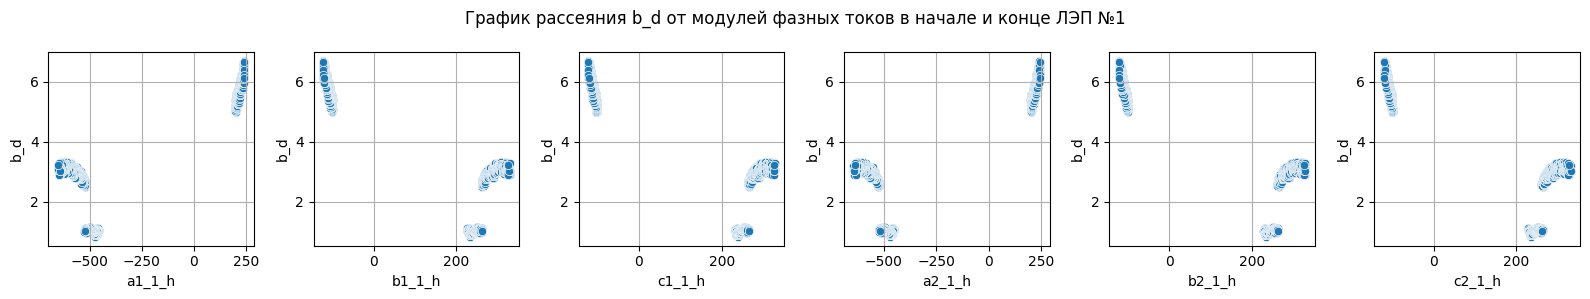

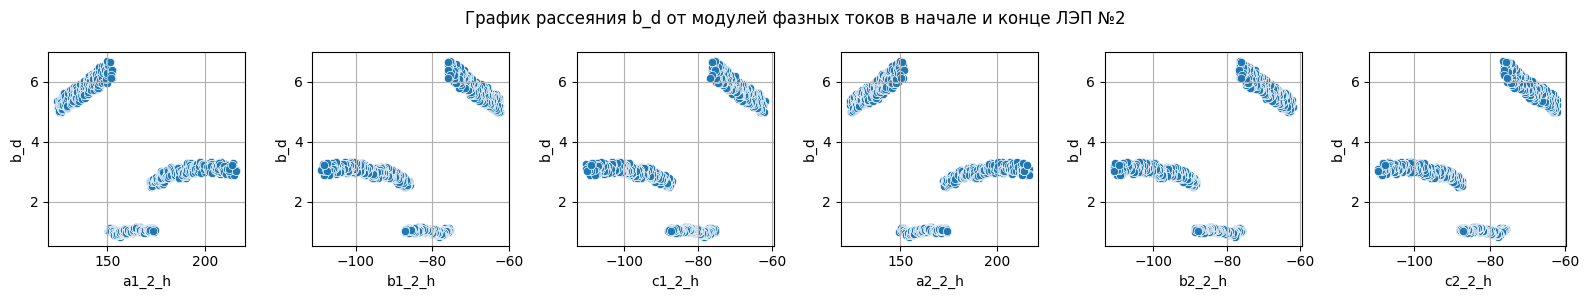

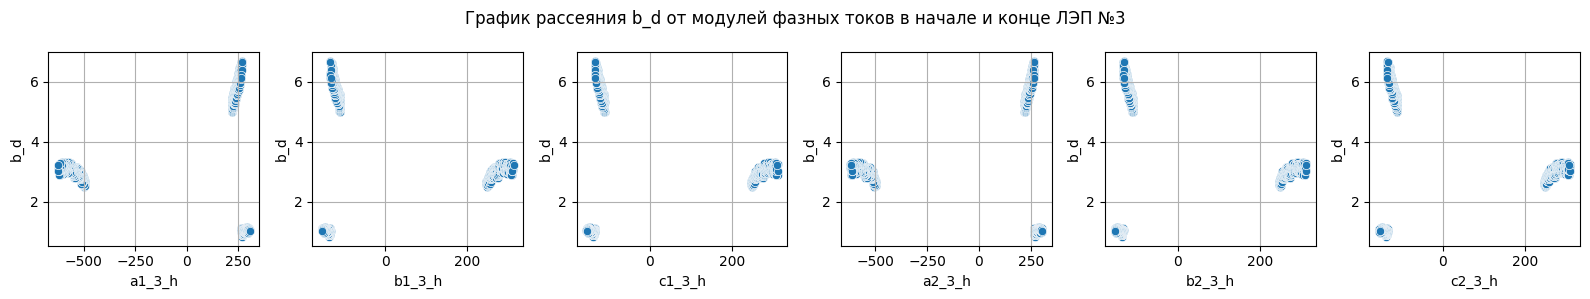

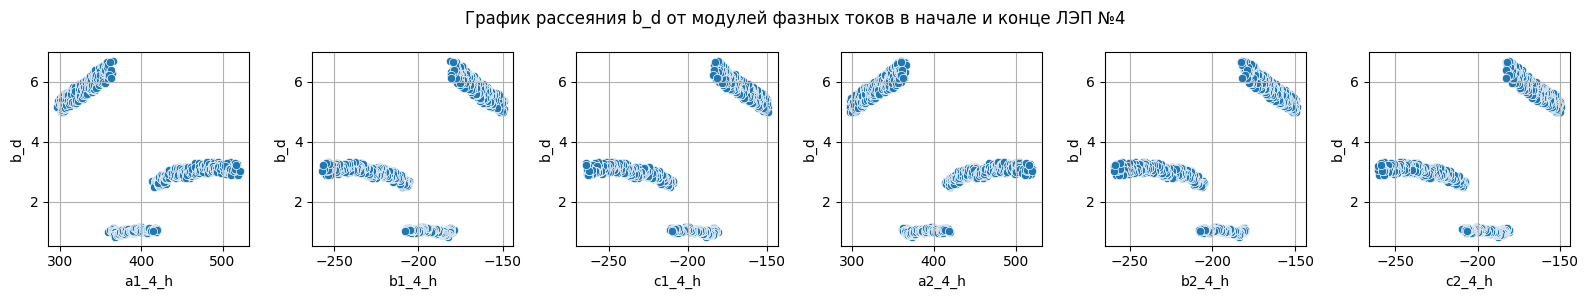

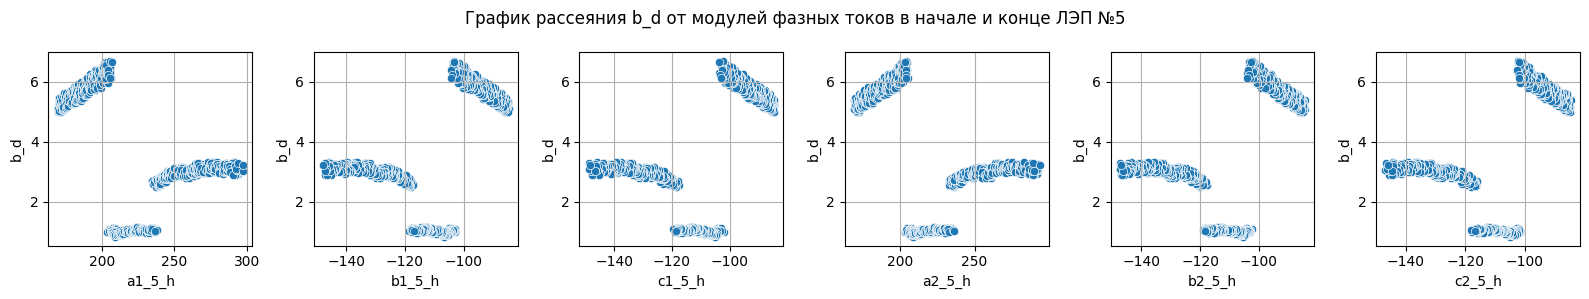

In [118]:
real_parts_predictors = df_complex.iloc[:, :-1].applymap(lambda x: x.real)
target_module = abs(df_complex.iloc[:, -1])
df_modul = pd.concat([real_parts_predictors, target_module], axis=1)
# df_modul = df_complex.applymap(lambda x: abs(x))

# Размер группы столбцов
group_size = 6

# Последний столбец
last_column = df_modul.columns[-1]

# Количество столбцов в датафрейме (кроме последнего)
num_columns = len(df_modul.columns) - 1

# Разделение столбцов на группы и создание графиков
group_number = 1  # Начальный номер группы
for i in range(0, num_columns, group_size):
    group = df_modul.columns[i:i + group_size]
    num_plots = len(group)
    
    # Создание сетки для графиков
    fig, axes = plt.subplots(1, num_plots, figsize=(16, 3))
    
    # Построение графиков рассеяния
    for j, column in enumerate(group):
        sns.scatterplot(data=df_modul, x=column, y=last_column, ax=axes[j], marker='o')
        axes[j].set_xlabel(column)
        axes[j].set_ylabel(last_column)
        axes[j].grid(True)  # Добавление линий сетки
    
    fig.suptitle(f'График рассеяния {last_column} от модулей фазных токов в начале и конце ЛЭП №{group_number}')
    group_number += 1
    plt.tight_layout()
    plt.show()

8 Среднеквадратичное значение b_d

In [119]:
std_b_d = np.sqrt(np.mean(np.abs(df_complex['b_d']) ** 2))
print(f'Среднеквадратичное значение b_d = {std_b_d.round(1)}')

Среднеквадратичное значение b_d = 4.0


9 Датасет тока небаланса для матрицы A_h и вектора b_d, заданных с погрешностями k_A и k_b

In [120]:
df_sum = pd.DataFrame()

for i in range(0, N_powerlines * N_feat, 3):
    feature_group = df_complex.iloc[:, i:i+3]  # Выбираем текущий тройной набор признаков
    sum_features = feature_group.sum(axis=1)  # Суммируем признаки в текущем тройном наборе
    df_sum[f'Jo_{i//3 + 1}'] = sum_features 

df_sum['b_d'] = df_complex['b_d']
df_sum.head()

,Jo_1,Jo_2,Jo_3,Jo_4,Jo_5,Jo_6,Jo_7,Jo_8,Jo_9,Jo_10,b_d
0,-0.966736-0.449762j,-1.441735+1.206870j,-0.410802+0.030868j,-1.115093-1.096814j,0.336586-0.395909j,-0.785428-2.015492j,1.383161-3.007138j,-4.412963+1.068823j,2.147799-0.133887j,-0.158458-0.496074j,4.895810-1.876515j
1,-0.701702+1.202828j,2.906699+0.643906j,-1.195976-0.299339j,-0.760209+0.128751j,-0.448958-0.279000j,1.306218+1.698746j,3.240343+2.594399j,-1.897491+2.340142j,0.330662+1.642410j,1.518046+2.384863j,4.753753-1.829324j
2,1.662956+0.413250j,1.751183-0.547539j,-0.519279-0.986649j,-0.501617-0.028849j,1.057199-0.034966j,-1.850007-1.815227j,3.840055+0.860161j,1.377108-0.407097j,1.002161+0.392771j,-0.535172+0.792189j,4.995858-1.928262j
3,-3.279249-1.017085j,-2.540387+0.000584j,-0.562695+0.570475j,1.367408+0.939005j,-0.167759-0.785730j,-0.867258-0.398701j,-3.362272-4.493868j,-0.276444+0.613770j,-0.783628-0.558854j,0.262618+0.411601j,4.822412-1.861522j
4,-0.865166+1.483319j,-2.474446-0.016149j,-0.177768+0.267015j,0.216116-0.150544j,-0.100745+0.223737j,-1.235175-0.921775j,-1.012553+1.099118j,-2.782137+3.299102j,-0.179204-2.178033j,0.406405+0.117613j,5.017751-1.939957j


In [121]:
# np.max(np.abs(df_complex))

10 Наибольшие значения токов фазы А в началах и концах ЛЭП

In [122]:
np.max(np.abs(df_complex.iloc[:, ::3]), axis=0)

a1_1_h    653.233072
a2_1_h    646.037529
a1_2_h    215.892139
a2_2_h    216.619128
a1_3_h    627.052043
a2_3_h    619.239719
a1_4_h    521.700028
a2_4_h    519.956697
a1_5_h    297.405814
a2_5_h    293.687693
b_d         6.690652
dtype: float64

11 Наибольшие значения токов небаланса (утроенных токов нулевой последовательности) в началах и концах ЛЭП

In [123]:
np.max(np.abs(df_sum))

c:\Python\Python39\lib\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)


Jo_1     20.599713
Jo_2     24.996207
Jo_3      7.817853
Jo_4      7.786762
Jo_5     14.880829
Jo_6     15.902236
Jo_7     20.287755
Jo_8     14.631317
Jo_9      7.552165
Jo_10     7.055864
b_d       6.690652
dtype: float64

In [124]:
# Вычисление долей наибольшего и ср.квадр. модулей тока небаланса от наибольшего модуля тока фазы А для каждой ЛЭП
df_sum = pd.DataFrame()

for i in range(0, len(df_complex.iloc[0])-1, 3):
    feature_group = df_complex.iloc[:, i:i+3]
    sum_features = feature_group.sum(axis=1)
    df_sum[f'Jo_{i//3 + 1}'] = sum_features

df_sum['b_d'] = df_complex['b_d']
df_sum.columns = df_complex.iloc[:, ::3].columns
df_unbal = np.abs(df_sum) / np.abs(df_complex.iloc[:, ::3])
max_relative_unbalance = np.max(df_unbal, axis=0)

IA_values = np.max(np.abs(df_complex.iloc[:, ::3]), axis=0)
max_values = np.max(np.abs(df_sum), axis=0)
rms_values = np.sqrt(np.mean(np.abs(df_sum) ** 2, axis=0))

IA_values = IA_values.reset_index(drop=True)
max_values.index = IA_values.index
rms_values.index = IA_values.index
max_relative_unbalance.index = IA_values.index

delta_max = max_values / IA_values
delta_rms = rms_values / IA_values
unbalance_df = pd.DataFrame({
    'IA_max, A': IA_values.round(1),
    'max(3I0/IA_max)': max_relative_unbalance,
    '3I0_max/IA_max': delta_max,
    '3I0_rms/IA_max': delta_rms
})
unbalance_df = unbalance_df.rename(index={unbalance_df.index[-1]: 'U_induced_max'})
unbalance_df.T.round(3)

,0,1,2,3,4,5,6,7,8,9,U_induced_max
"IA_max, A",653.200,646.000,215.900,216.600,627.100,619.200,521.700,520.000,297.400,293.700,6.700
max(3I0/IA_max),0.033,0.040,0.040,0.041,0.026,0.036,0.041,0.032,0.028,0.032,1.000
3I0_max/IA_max,0.032,0.039,0.036,0.036,0.024,0.026,0.039,0.028,0.025,0.024,1.000
3I0_rms/IA_max,0.010,0.012,0.015,0.015,0.007,0.009,0.016,0.011,0.010,0.010,0.591


12 Корреляционная матрица

In [125]:
# plt.figure(figsize=(10, 8))
# sns.heatmap(df_modul.corr(method='pearson').round(2), annot=True, annot_kws={"fontsize": 9}, cmap='coolwarm', linewidth=.5)
# sns.set(rc={"xtick.labelsize":10, "ytick.labelsize":10})
# plt.xticks(rotation=35, ha='right')
# plt.title('Pearson')
# plt.show()

In [126]:
end_time = time.time()
minutes, seconds = divmod(end_time - start_time, 60)

print(f'Время выполнения кода: {int(minutes)} мин {seconds:.1f} сек')

Время выполнения кода: 0 мин 18.3 сек
